# Helping functions and Imports

## Imports

In [1]:
import os
import json
from tqdm import tqdm
import re
import time
import random
import pandas as pd

## IO Utils

In [2]:
"""
Contains some utils functions for io operations.
"""

import json
import os
import pickle
import csv
import requests


def path_exits(path):
    return os.path.exists(path)


def mkdir(path):
    if not path_exits(path):
        os.mkdir(path)


def makedirs(path):
    if not path_exits(path):
        os.makedirs(path)


def list_files_in_dir(dir):
    return [file for file in os.listdir(dir) if is_file(join(dir, file))]


def list_directories(dir):
    return [subdir for subdir in os.listdir(dir) if os.path.isdir(join(dir, subdir))]


def is_file(path):
    return os.path.isfile(path)


def is_dir(path):
    return os.path.isdir(path)


def join(path1, path2):
    return os.path.join(path1, path2)


def write_json(path, dict):
    with open(path, 'w') as outfile:
        json.dump(dict, outfile, indent=2)
    outfile.close()


def read_json(path):
    with open(path, "r") as infile:
        data = json.load(infile)
    infile.close()
    return data


def read_file_into_list(input_file):
    lines = []
    with open(input_file, "r") as infile_fp:
        for line in infile_fp.readlines():
            lines.append(line.strip())
    infile_fp.close()
    return lines


def write_list_to_file(output_file, list):
    with open(output_file, "w") as outfile_fp:
        for line in list:
            outfile_fp.write(line + "\r\n")
    outfile_fp.close()


def write_text_to_file(output_file, text):
    with open(output_file, "w") as output_fp:
        output_fp.write(text)
    output_fp.close()


def write_pickle(data, file_path):
    pickle.dump(data, open(file_path, "wb"))


def read_pickle(file_path):
    return pickle.load(open(file_path, 'rb'))


def write_to_csv(filepath, header, rows, delimiter=','):
    with open(filepath, 'w', encoding='UTF8', newline='') as output_fp:
        writer = csv.writer(output_fp, delimiter=delimiter)
        writer.writerow(header)
        writer.writerows(rows)
    output_fp.close()

def get_request_content(end_point, params):
    get_response = requests.get(end_point, params=params)
    return get_response.json()


def download_file(url, download_path):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:55.0) Gecko/20100101 Firefox/55.0',
    }
    r = requests.get(url, stream=True, allow_redirects=True, headers=headers)
    with open(download_path, 'wb') as f:
        for ch in r:
            f.write(ch)

def write_dict_to_csv(filepath, fields, dict):
  with open(filepath, 'w') as csvfile:
    # creating a csv dict writer object
    writer = csv.DictWriter(csvfile, fieldnames=fields)

    # writing headers (field names)
    writer.writeheader()

    # writing data rows
    writer.writerows(dict)

# Input and output information
Include any paths required for input or output

## Manually Collected papers

#### Interviews

In [4]:
# /path/to/nkd_llm_2024/: https://anonymous.4open.science/r/nkd_llm_2024-07E6
# TODO: set the correct path
interviews_papers_base_dir = "/path/to/nkd_llm_2024/data/interviews"

In [5]:
interviews_predictions_base_path = join(interviews_papers_base_dir, 'predictions')

### Surveys

In [6]:
# /path/to/nkd_llm_2024/: https://anonymous.4open.science/r/nkd_llm_2024-07E6
# TODO: set the correct path
surveys_papers_base_dir = "/path/to/nkd_llm_2024/data/surveys"

In [7]:
surveys_predictions_base_path = join(surveys_papers_base_dir, 'predictions')

# Analysis

## Statistics

In [8]:
def collect_claim_prediction_statistics(prediction_file_path):
  lines = read_file_into_list(prediction_file_path)

  support_count = 0
  contradict_count = 0
  not_found_count = 0
  support_sent_count = 0
  contradict_sent_count = 0
  claims_count = len(lines)

  for line in lines:
    line = json.loads(line)
    if not line['evidence']:
      not_found_count += 1
      continue
    support_sent_count_per_claim = 0
    contradict_sent_count_per_claim = 0
    for doc_id in line['evidence']:
      if line['evidence'][doc_id]['label'] == 'SUPPORT':
        # support_count += 1
        support_sent_count_per_claim += len(line['evidence'][doc_id]['sentences'])
        support_sent_count += len(line['evidence'][doc_id]['sentences'])
      else:
        # contradict_count += 1
        contradict_sent_count_per_claim += len(line['evidence'][doc_id]['sentences'])
        contradict_sent_count += len(line['evidence'][doc_id]['sentences'])
    if support_sent_count_per_claim > contradict_sent_count_per_claim:
      support_count += 1
    else:
      contradict_count += 1

  return support_count, contradict_count, not_found_count, support_sent_count, contradict_sent_count, claims_count

In [9]:
def add_row_to_count_statistics(count_statistics, prediction_file_path, llm_type, run_number, prompt_version, claim_type, corpus_type):
  if not path_exits(prediction_file_path):
    print("file doesn't exist", prediction_file_path)
    return
  support_count, contradict_count, not_found_count, support_sent_count, contradict_sent_count, claims_count = collect_claim_prediction_statistics(prediction_file_path)
  count_statistics.append({
      "llm": llm_type,
      "run": run_number,
      "prompt": prompt_version,
      "claim_type": claim_type,
      "corpus_type": corpus_type,
      "support_count": support_count,
      "support_sent_count": support_sent_count,
      "avg_supported_sent": 0 if support_count == 0 else support_sent_count / support_count,
      "contradict_count": contradict_count,
      "contradict_sent_count": contradict_sent_count,
      "avg_contradict_sent": 0 if contradict_count == 0 else contradict_sent_count/ contradict_count,
      "not_found_count": not_found_count,
      "claims_count": claims_count
  })


In [10]:
def calculate_percentages(count_statistics_df):
  count_statistics_df['support_percentage'] = count_statistics_df['support_count'] / count_statistics_df['claims_count']
  count_statistics_df['contradict_percentage'] = count_statistics_df['contradict_count'] / count_statistics_df['claims_count']
  count_statistics_df['not_found_percentage'] = count_statistics_df['not_found_count'] / count_statistics_df['claims_count']

## Plots

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### bar plots

In [12]:
def draw_bar_plot(x_col, y_col, divide_by, statistics_df, legend_title, y_label , x_order=None):
  if x_order:
    statistics_df[x_col] = pd.Categorical(statistics_df[x_col], categories=x_order, ordered=True)
  plt.figure(figsize=(8, 4))
  plt.rcParams.update({'font.size': 14})
  sns.barplot(x=x_col, y=y_col, hue=divide_by, data=statistics_df, palette='Set2')
  plt.ylim(0, 1)
  plt.ylabel(y_label)
  plt.xlabel('')
  plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

### Box plot

In [13]:
def draw_box_plot(x_col, y_col, divide_by, statistics_df, legend_title, y_label , x_order=None):
  if x_order:
    statistics_df[x_col] = pd.Categorical(statistics_df[x_col], categories=x_order, ordered=True)
  plt.figure(figsize=(8, 4))
  plt.rcParams.update({'font.size': 14})
  sns.boxplot(x=x_col, y=y_col, hue=divide_by, data=statistics_df, palette='Set2')
  plt.ylim(0, 1)
  plt.ylabel(y_label)
  plt.xlabel('')
  plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.show()

# Full process

In [14]:
def add_general_claims_to_count_statistics_prompts(predictions_base_dir, count_statistics, claims_types, corpus_types):
  for llm in list_directories(predictions_base_dir):
    for prompt in list_directories(join(predictions_base_dir, llm)):
      for run in list_directories(join(predictions_base_dir, f'{llm}/{prompt}')):
        for claim in claims_types:
          for corpus in corpus_types:
            prediction_file_path = join(predictions_base_dir, f'{llm}/{prompt}/{run}/{claim}_{corpus}.jsonl')
            add_row_to_count_statistics(count_statistics, prediction_file_path, llm, run, prompt, claim, corpus)

In [15]:
def add_difference_to_count_statistics_prompts(predictions_base_dir, count_statistics):
  for llm in list_directories(predictions_base_dir):
    for prompt in list_directories(join(predictions_base_dir, llm)):
      for run in list_directories(join(predictions_base_dir, f'{llm}/{prompt}')):
        prediction_file_path = join(predictions_base_dir, f'{llm}/{prompt}/{run}/raw_keydifferences.jsonl')
        add_row_to_count_statistics(count_statistics, prediction_file_path, llm, run, prompt, 'raw_keydifferences', 'difference')

In [16]:
def generate_count_statitics_df_prompt(predictions_base_dir, claims_types, corpus_types, count_statistics_out_path):
  count_statistics = []
  add_general_claims_to_count_statistics_prompts(predictions_base_dir, count_statistics, claims_types, corpus_types)
  add_difference_to_count_statistics_prompts(predictions_base_dir, count_statistics)
  count_statistics_df = pd.DataFrame(count_statistics)
  calculate_percentages(count_statistics_df)
  count_statistics_df.to_csv(count_statistics_out_path)
  return count_statistics_df

## Manually collected

In [17]:
prompt_name_detailed_info_zero_vs_few_map = {
    'prompt_v1': {'KD template': 'no_template', 'context': 'fulltext', 'examples': 'zero'},
    'prompt_v2': {'KD template': 'template', 'context': 'fulltext', 'examples': 'zero'},
    'prompt_v3': {'KD template': 'template', 'context': 'fulltext', 'examples': 'few'},
    'prompt_few_shots_v1': {'KD template': 'no_template', 'context': 'fulltext', 'examples': 'few'},
    }

In [18]:
prompt_name_detailed_info_full_vs_az_map = {
    'prompt_v3': {'KD template': 'template', 'context': 'fulltext', 'examples': 'few'},
    'az_label_prompt_v3': {'KD template': 'template', 'context': 'az', 'examples': 'few'},
    }

In [19]:
def get_comparison_df(count_statistics_df, prompt_detailed_info_map):
  comparison_rows = []
  for index, row in count_statistics_df.iterrows():
    if row['prompt'] not in prompt_detailed_info_map:
      continue
    comparison_rows.append({
        'llm': row['llm'],
        'run': row['run'],
        'KD template': prompt_detailed_info_map[row['prompt']]['KD template'],
        'context': prompt_detailed_info_map[row['prompt']]['context'],
        'examples': prompt_detailed_info_map[row['prompt']]['examples'],
        'support_count': row['support_count'],
        "support_sent_count": row['support_sent_count'],
        "avg_supported_sent": row['avg_supported_sent'],
        "contradict_count": row['contradict_count'],
        "contradict_sent_count": row['contradict_sent_count'],
        "avg_contradict_sent": row['avg_contradict_sent'],
        "not_found_count": row['not_found_count'],
        "claims_count": row['claims_count'],
        'support_percentage': row['support_percentage'],
        'contradict_percentage': row['contradict_percentage'],
        'not_found_percentage': row['not_found_percentage']
    })
  return pd.DataFrame.from_dict(comparison_rows)

### Interviews

In [ ]:
interviews_count_statistics_df = generate_count_statitics_df_prompt(interviews_predictions_base_path, [], [], join(interviews_predictions_base_path, 'count_statistics_prompts.csv'))

#### zero vs few shots

In [21]:
interviews_zero_vs_few_df = get_comparison_df(interviews_count_statistics_df, prompt_name_detailed_info_zero_vs_few_map)

In [22]:
interviews_zero_vs_few_df_avg = interviews_zero_vs_few_df.drop(columns=['run'])
interviews_zero_vs_few_df_avg = interviews_zero_vs_few_df_avg.groupby(['llm', 'KD template', 'context', 'examples']).mean().reset_index()
interviews_zero_vs_few_df_avg['kd_template_examples'] = interviews_zero_vs_few_df_avg['KD template'] + '__' + interviews_zero_vs_few_df_avg['examples']
x_label_mapping = {
    'no_template__few': 'no template\nfew-shot',
    'no_template__zero': 'no template\nzero-shot',
    'template__few': 'template\nfew-shot',
    'template__zero': 'template\nzero-shot'
}
interviews_zero_vs_few_df_avg['kd_template_examples'] = interviews_zero_vs_few_df_avg['kd_template_examples'].map(x_label_mapping)

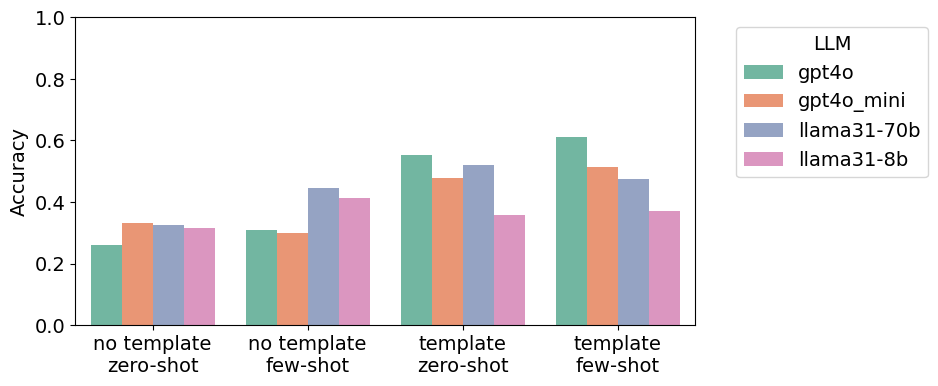

In [23]:
x_order = ['no_template__zero', 'no_template__few', 'template__zero', 'template__few']
x_order = ['no template\nzero-shot', 'no template\nfew-shot', 'template\nzero-shot', 'template\nfew-shot']
draw_bar_plot('kd_template_examples', 'support_percentage', 'llm', interviews_zero_vs_few_df_avg, 'LLM', 'Accuracy', x_order=x_order)

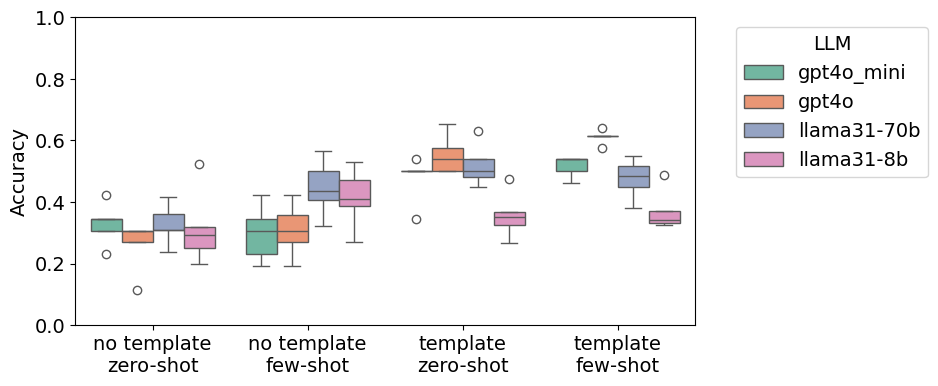

In [25]:
interviews_zero_vs_few_df['kd_template_examples'] = interviews_zero_vs_few_df['KD template'] + '__' + interviews_zero_vs_few_df['examples']
x_label_mapping = {
    'no_template__few': 'no template\nfew-shot',
    'no_template__zero': 'no template\nzero-shot',
    'template__few': 'template\nfew-shot',
    'template__zero': 'template\nzero-shot'
}
interviews_zero_vs_few_df['kd_template_examples'] = interviews_zero_vs_few_df['kd_template_examples'].map(x_label_mapping)
x_order = ['no template\nzero-shot', 'no template\nfew-shot', 'template\nzero-shot', 'template\nfew-shot']
draw_box_plot('kd_template_examples', 'support_percentage', 'llm', interviews_zero_vs_few_df, 'LLM', 'Accuracy', x_order=x_order)

#### fulltext vs az

In [31]:
interviews_full_vs_az_df = get_comparison_df(interviews_count_statistics_df, prompt_name_detailed_info_full_vs_az_map)

In [27]:
interviews_full_vs_az_df_avg = interviews_full_vs_az_df.drop(columns=['run'])
interviews_full_vs_az_df_avg = interviews_full_vs_az_df_avg.groupby(['llm', 'KD template', 'context', 'examples']).mean().reset_index()
x_label_mapping = {
    'az': 'az summary',
    'fulltext': 'full text',
}
interviews_full_vs_az_df_avg['context'] = interviews_full_vs_az_df_avg['context'].map(x_label_mapping)

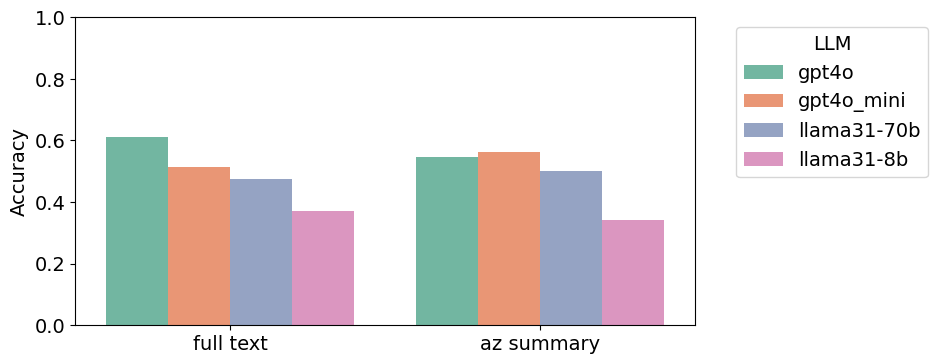

In [28]:
x_order = ['full text', 'az summary']
draw_bar_plot('context', 'support_percentage', 'llm', interviews_full_vs_az_df_avg, 'LLM', 'Accuracy', x_order=x_order)

In [32]:
interviews_full_vs_az_df = interviews_full_vs_az_df.drop(columns=['run'])
x_label_mapping = {
    'az': 'az summary',
    'fulltext': 'full text',
}
interviews_full_vs_az_df['context'] = interviews_full_vs_az_df['context'].map(x_label_mapping)

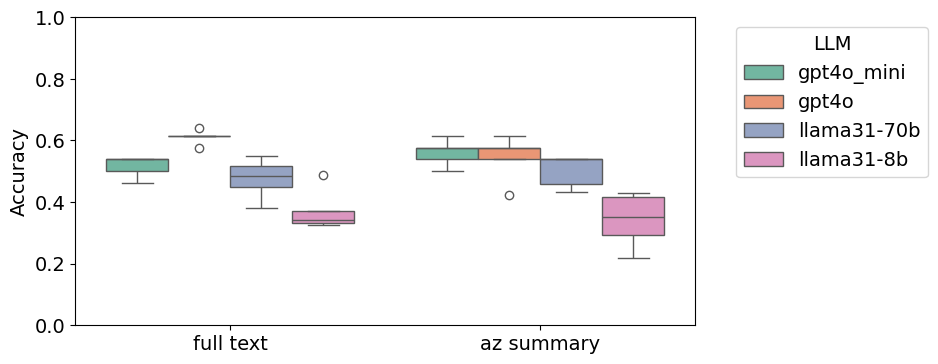

In [33]:
x_order = ['full text', 'az summary']
draw_box_plot('context', 'support_percentage', 'llm', interviews_full_vs_az_df, 'LLM', 'Accuracy', x_order=x_order)

### Surveys

In [34]:
surveys_count_statistics_df = generate_count_statitics_df_prompt(surveys_predictions_base_path, [], [], join(surveys_predictions_base_path, 'count_statistics_prompts.csv'))

#### zero vs few shots

In [41]:
surveys_zero_vs_few_df = get_comparison_df(surveys_count_statistics_df, prompt_name_detailed_info_zero_vs_few_map)

In [36]:
surveys_zero_vs_few_df_avg = surveys_zero_vs_few_df.drop(columns=['run'])
surveys_zero_vs_few_df_avg = surveys_zero_vs_few_df_avg.groupby(['llm', 'KD template', 'context', 'examples']).mean().reset_index()
surveys_zero_vs_few_df_avg['kd_template_examples'] = surveys_zero_vs_few_df_avg['KD template'] + '__' + surveys_zero_vs_few_df_avg['examples']
x_label_mapping = {
    'no_template__few': 'no template\nfew-shot',
    'no_template__zero': 'no template\nzero-shot',
    'template__few': 'template\nfew-shot',
    'template__zero': 'template\nzero-shot'
}
surveys_zero_vs_few_df_avg['kd_template_examples'] = surveys_zero_vs_few_df_avg['kd_template_examples'].map(x_label_mapping)

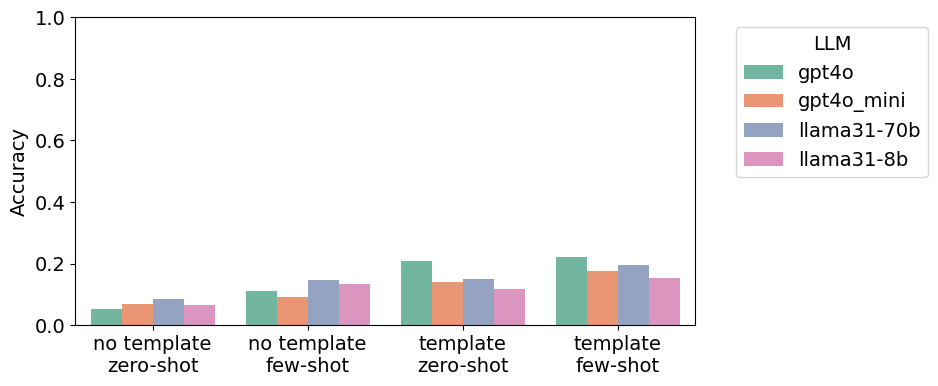

In [37]:
x_order = ['no template\nzero-shot', 'no template\nfew-shot', 'template\nzero-shot', 'template\nfew-shot']
draw_bar_plot('kd_template_examples', 'support_percentage', 'llm', surveys_zero_vs_few_df_avg, 'LLM', 'Accuracy', x_order=x_order)

In [42]:
surveys_zero_vs_few_df = surveys_zero_vs_few_df.drop(columns=['run'])
surveys_zero_vs_few_df['kd_template_examples'] = surveys_zero_vs_few_df['KD template'] + '__' + surveys_zero_vs_few_df['examples']
x_label_mapping = {
    'no_template__few': 'no template\nfew-shot',
    'no_template__zero': 'no template\nzero-shot',
    'template__few': 'template\nfew-shot',
    'template__zero': 'template\nzero-shot'
}
surveys_zero_vs_few_df['kd_template_examples'] = surveys_zero_vs_few_df['kd_template_examples'].map(x_label_mapping)

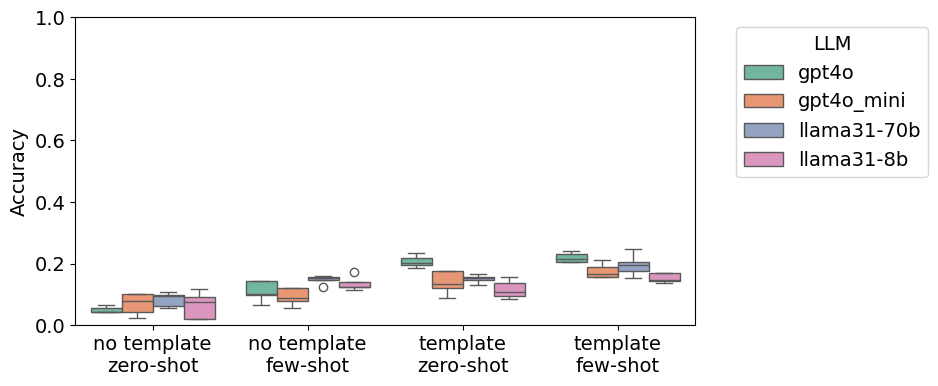

In [43]:
x_order = ['no template\nzero-shot', 'no template\nfew-shot', 'template\nzero-shot', 'template\nfew-shot']
draw_box_plot('kd_template_examples', 'support_percentage', 'llm', surveys_zero_vs_few_df, 'LLM', 'Accuracy', x_order=x_order)

#### fulltext vs az

In [44]:
surveys_full_vs_az_df = get_comparison_df(surveys_count_statistics_df, prompt_name_detailed_info_full_vs_az_map)

In [45]:
surveys_full_vs_az_df_avg = surveys_full_vs_az_df.drop(columns=['run'])
surveys_full_vs_az_df_avg = surveys_full_vs_az_df_avg.groupby(['llm', 'KD template', 'context', 'examples']).mean().reset_index()
x_label_mapping = {
    'az': 'az summary',
    'fulltext': 'full text',
}
surveys_full_vs_az_df_avg['context'] = surveys_full_vs_az_df_avg['context'].map(x_label_mapping)

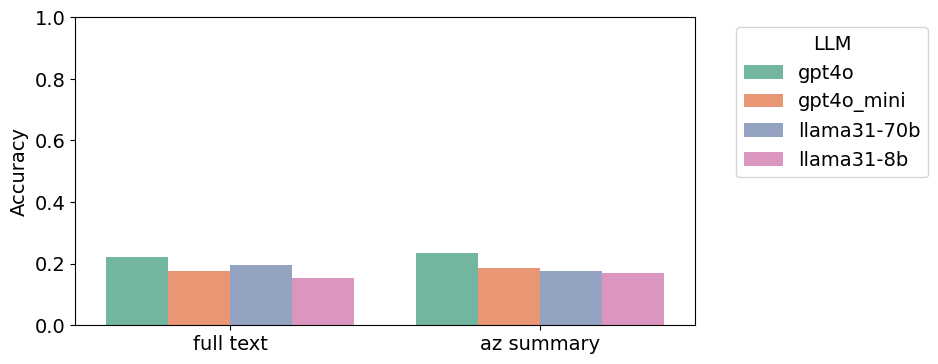

In [46]:
x_order = ['full text', 'az summary']
draw_bar_plot('context', 'support_percentage', 'llm', surveys_full_vs_az_df_avg, 'LLM', 'Accuracy', x_order=x_order)

In [47]:
surveys_full_vs_az_df = surveys_full_vs_az_df.drop(columns=['run'])
x_label_mapping = {
    'az': 'az summary',
    'fulltext': 'full text',
}
surveys_full_vs_az_df['context'] = surveys_full_vs_az_df['context'].map(x_label_mapping)

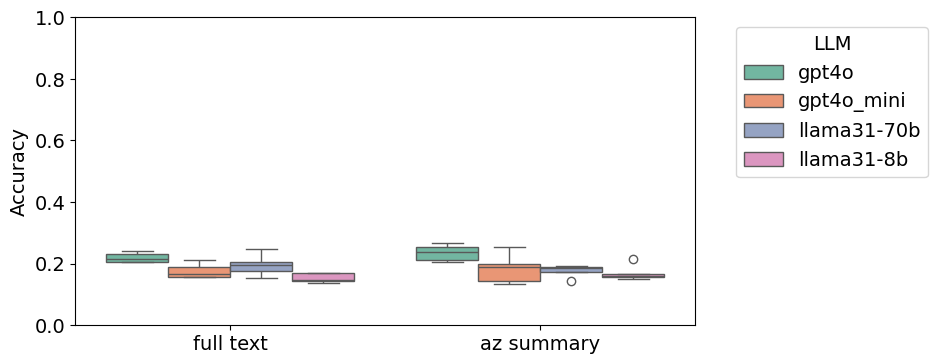

In [48]:
x_order = ['full text', 'az summary']
draw_box_plot('context', 'support_percentage', 'llm', surveys_full_vs_az_df, 'LLM', 'Accuracy', x_order=x_order)